In [2]:
from pyspark.sql import SparkSession

# Core Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

# Set color palette for Seaborn
colors = ["#26536f", "#3b96b7", "#749ca8", "#b6a98d", "#c78a4d", "#854927"]
sns.set_palette(colors)

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
)

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName("Ecommerce_Analysis").getOrCreate()

In [4]:
# Load the dataset (Replace 'dataset.csv' with the actual file path)
df = spark.read.csv("Ecommerce.csv", header=True, inferSchema=True)

In [5]:
# Display schema to check data types
df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)
 |-- order_item_id: double (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- freight_value: string (nullable = true)
 |-- payment_sequential: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: string (nullable = true)
 |-- payment_value: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_score: string (nullable = true)
 |-- review_comment_title: string (nullable 

In [6]:
df.count()

123553

In [7]:
# Show first few records
df.show()

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+-------------+--------------------+--------------------+-------------------+------+-------------+------------------+------------+--------------------+-------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+--------------------+------------------------+--------------------+--------------+----------------------+--------------------+------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|          product_id|

# Handling Missing Values

In [9]:
from pyspark.sql.functions import col, sum

# Count missing/null values in each column
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

+--------+-----------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-------------+----------+---------+-------------------+-----+-------------+------------------+------------+--------------------+-------------+---------+------------+--------------------+----------------------+--------------------+-----------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+------------------+------------------------+-------------+--------------+----------------------+-----------+------------+
|order_id|customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|product_id|seller_id|shipping_limit_date|price|freight_value|payment_sequential|payment_type|payment_installments|paym

### Step 1: Drop Columns with Excessive Missing Values
If certain columns have a very high percentage of missing values (e.g., review_comment_title, review_comment_message), it's better to drop them.

In [11]:
df = df.drop("review_comment_title", "review_comment_message", "product_name_lenght", "product_description_lenght","product_photos_qty", "product_weight_g","product_height_cm", "product_width_cm","product_length_cm", "customer_unique_id", "customer_zip_code_prefix", "seller_zip_code_prefix")

### Step 2: Fill Missing Values for Important Columns

In [13]:
from pyspark.sql.functions import mean

num_cols = ["price", "freight_value"]

for col_name in num_cols:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]
    df = df.fillna({col_name: mean_value})

In [14]:
cat_cols = ["product_category_name", "customer_city", "customer_state", "seller_city", "seller_state"]

for col_name in cat_cols:
    df = df.fillna({col_name: "Unknown"})

In [15]:
from pyspark.sql.functions import to_date, lit

date_cols = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
             "order_delivered_customer_date", "order_estimated_delivery_date",
             "shipping_limit_date", "review_creation_date", "review_answer_timestamp"]

for col_name in date_cols:
    df = df.fillna({col_name: "1970-01-01"})
    df = df.withColumn(col_name, to_date(col(col_name)))

In [16]:
df = df.dropna(subset=["order_delivered_customer_date", "review_score", "order_item_id","review_creation_date","review_answer_timestamp","order_purchase_timestamp"])

In [17]:
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

+--------+-----------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+-------------+----------+---------+-------------------+-----+-------------+------------------+------------+--------------------+-------------+---------+------------+--------------------+-----------------------+---------------------+-------------+--------------+-----------+------------+
|order_id|customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|order_item_id|product_id|seller_id|shipping_limit_date|price|freight_value|payment_sequential|payment_type|payment_installments|payment_value|review_id|review_score|review_creation_date|review_answer_timestamp|product_category_name|customer_city|customer_state|seller_city|seller_state|
+--------+-----------+------------+------------------------+-----------------+--------------

In [18]:
df.count()

117249

In [19]:
df = df.toPandas()

In [20]:
unique_id = df['customer_id'].unique()
id_mapping = {old_id : new_id for new_id, old_id in enumerate(unique_id, start= 1)}
df['customer_id'] = df['customer_id'].map(id_mapping)

In [21]:
unique_id = df['product_id'].unique()
id_mapping = {old_id : new_id for new_id, old_id in enumerate(unique_id, start= 1)}
df['product_id'] = df['product_id'].map(id_mapping)

In [22]:
# Ensure timestamps are in datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Create useful features from order_purchase_timestamp
df['day_of_week_int'] = df['order_purchase_timestamp'].dt.weekday + 1  # Day of week as integer (1 = Monday, etc.)
df['hour'] = df['order_purchase_timestamp'].dt.hour                    # Hour of day
df['month'] = df['order_purchase_timestamp'].dt.month                  # Month as integer
df['year'] = df['order_purchase_timestamp'].dt.year                    # Year as integer
df['date'] = df['order_purchase_timestamp'].dt.to_period('M')          # Monthly period for time series analysis

# Calculate delivery time in days
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

In [23]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [24]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,seller_city,seller_state,day_of_week_int,hour,month,year,date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,1,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
1,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,1,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
2,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,1,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
3,53cdb2fc8bc7dce0b6741e2150273451,2,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,1.0,2,...,barreiras,BA,belo horizonte,SP,2,0,7,2018,2018-07,14
4,47770eb9100c2d0c44946d9cf07ec65d,3,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,3,...,vianopolis,GO,guariba,SP,3,0,8,2018,2018-08,9


# EDA

### Monthly Sales Trend (Line Plot)

In [27]:
df.to_csv('ecommerce_cleaned.csv')

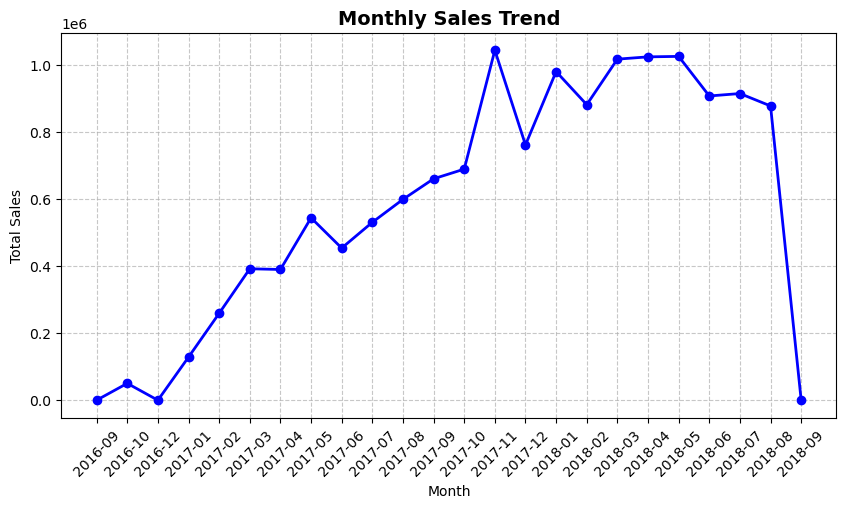

In [28]:
# Aggregate monthly sales
monthly_sales = df.groupby(df['order_purchase_timestamp'].dt.to_period('M'))['price'].sum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales.index.astype(str), monthly_sales, marker='o', linestyle='-', color='b', linewidth=2)

# Labels and formatting
plt.title('Monthly Sales Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Total Sales by Product Category (Bar Plot)

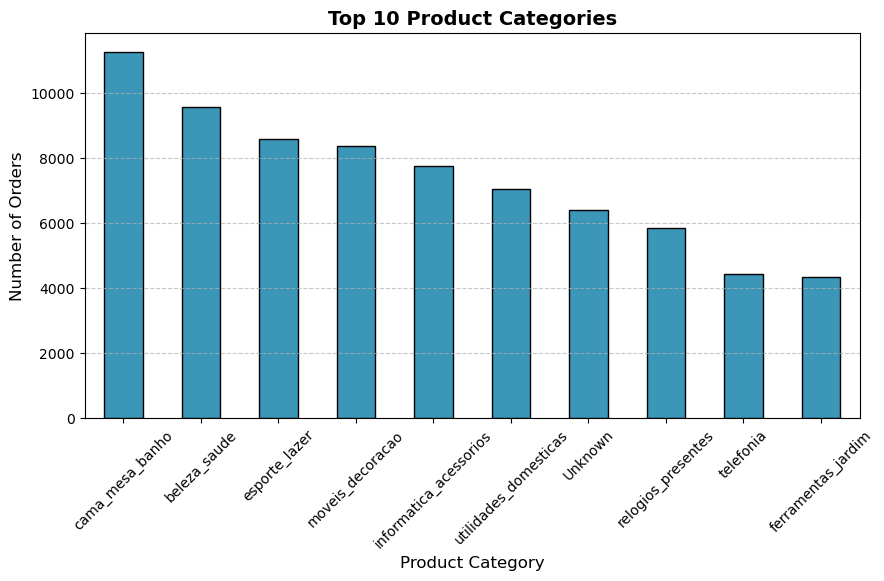

In [30]:
# Plot top 10 product categories
df['product_category_name'].value_counts().head(10).plot(
    kind='bar', figsize=(10, 5), color=colors[1], edgecolor='black'
)

# Add titles and labels
plt.title('Top 10 Product Categories', fontsize=14, fontweight='bold')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# Customize ticks and gridlines
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Proportion of Total Sales by Payment Type (Pie Chart)

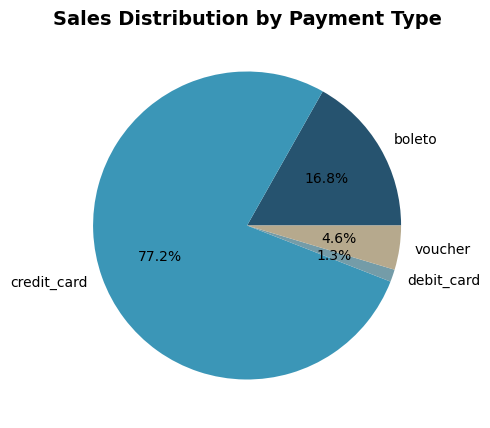

In [32]:
# Plot sales distribution by payment type
df.groupby('payment_type')['price'].sum().plot(
    kind='pie', autopct='%1.1f%%', colors=colors, figsize=(5,5), ylabel='')

# Add title
plt.title('Sales Distribution by Payment Type', fontsize=14, fontweight='bold')

plt.show()

### Distribution of Review Scores (Histogram)

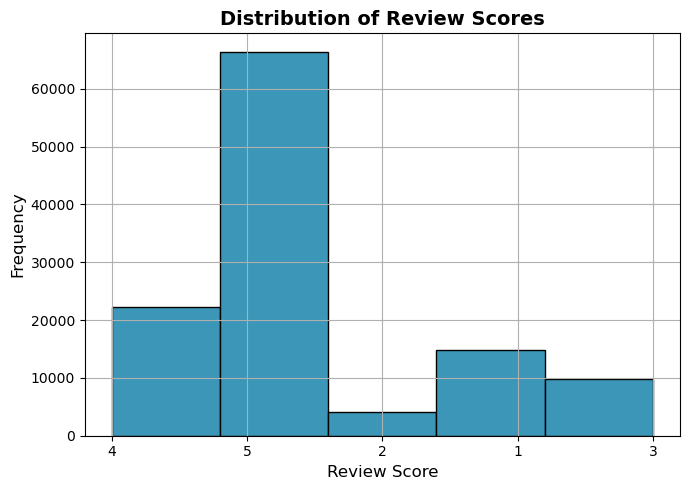

In [34]:
# Plot distribution of review scores
df['review_score'].hist(bins=5, color=colors[1], edgecolor='black', figsize=(7, 5), grid=True)

# Add title and labels
plt.title('Distribution of Review Scores', fontsize=14, fontweight='bold')
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()


### Correlation Heatmap

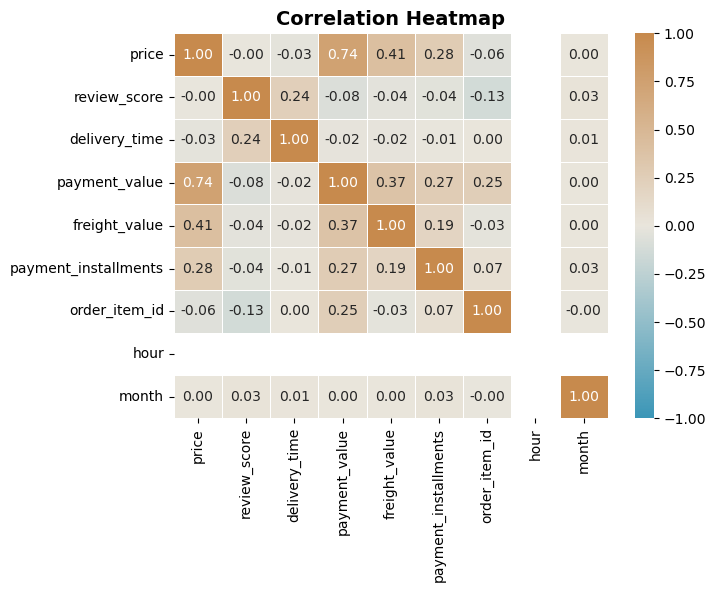

In [36]:
# Select relevant features and compute correlation matrix
correlation = df[['price', 'review_score', 'delivery_time',
                  'payment_value', 'freight_value', 'payment_installments',
                  'order_item_id', 'hour', 'month']].corr()

# Define custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#3B96B7', '#E9E5DC', '#C78A4D'])

# Plot heatmap
plt.figure(figsize=(7,5))
sns.heatmap(correlation, annot=True, cmap=custom_cmap, vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.show()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117249 entries, 0 to 117248
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117249 non-null  object        
 1   customer_id                    117249 non-null  int64         
 2   order_status                   117249 non-null  object        
 3   order_purchase_timestamp       117249 non-null  datetime64[ns]
 4   order_approved_at              117249 non-null  object        
 5   order_delivered_carrier_date   117249 non-null  object        
 6   order_delivered_customer_date  117249 non-null  datetime64[ns]
 7   order_estimated_delivery_date  117249 non-null  object        
 8   order_item_id                  117249 non-null  float64       
 9   product_id                     117249 non-null  int64         
 10  seller_id                      117249 non-null  object        
 11  

In [38]:
df.shape

(117249, 33)

# FEATURE ENGINEERING

In [40]:
df_sentiment = df.copy()
df_recommendation = df[['customer_id', 'product_id', 'review_score', 'product_category_name', 'price', 'freight_value']].copy()

In [41]:
df_sentiment.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,seller_city,seller_state,day_of_week_int,hour,month,year,date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,1,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
1,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,1,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
2,e481f51cbdc54678b7cc49136f2d6af7,1,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,1.0,1,...,sao paulo,SP,maua,SP,1,0,10,2017,2017-10,8
3,53cdb2fc8bc7dce0b6741e2150273451,2,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,1.0,2,...,barreiras,BA,belo horizonte,SP,2,0,7,2018,2018-07,14
4,47770eb9100c2d0c44946d9cf07ec65d,3,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,1.0,3,...,vianopolis,GO,guariba,SP,3,0,8,2018,2018-08,9


In [42]:
df_recommendation.head()

,customer_id,product_id,review_score,product_category_name,price,freight_value
0,1,1,4,utilidades_domesticas,29.99,8.72
1,1,1,4,utilidades_domesticas,29.99,8.72
2,1,1,4,utilidades_domesticas,29.99,8.72
3,2,2,4,perfumaria,118.70,22.76
4,3,3,5,automotivo,159.90,19.22


## Feature Engineering for Sentiment Analysis

In [44]:
df1 = df[['order_status', 'payment_type','price', 'freight_value','payment_sequential','payment_installments','payment_value','delivery_time','day_of_week_int','order_delivered_customer_date','order_estimated_delivery_date', 'product_category_name', 'customer_state', 'seller_state','review_score']]

In [45]:
df1.head()

,order_status,payment_type,price,freight_value,payment_sequential,payment_installments,payment_value,delivery_time,day_of_week_int,order_delivered_customer_date,order_estimated_delivery_date,product_category_name,customer_state,seller_state,review_score
0,delivered,credit_card,29.99,8.72,1,1,18.12,8,1,2017-10-10,2017-10-18,utilidades_domesticas,SP,SP,4
1,delivered,voucher,29.99,8.72,3,1,2.0,8,1,2017-10-10,2017-10-18,utilidades_domesticas,SP,SP,4
2,delivered,voucher,29.99,8.72,2,1,18.59,8,1,2017-10-10,2017-10-18,utilidades_domesticas,SP,SP,4
3,delivered,boleto,118.70,22.76,1,1,141.46,14,2,2018-08-07,2018-08-13,perfumaria,BA,SP,4
4,delivered,credit_card,159.90,19.22,1,3,179.12,9,3,2018-08-17,2018-09-04,automotivo,GO,SP,5


In [46]:
# Convert both columns to pandas Timestamps
df1['order_delivered_customer_date'] = pd.to_datetime(df1['order_delivered_customer_date'])
df1['order_estimated_delivery_date'] = pd.to_datetime(df1['order_estimated_delivery_date'])

# Now subtract the two columns
df1['delivery_delay'] = df1['order_delivered_customer_date'] - df1['order_estimated_delivery_date']

# Create the 'on_time_delivery' column
df1['on_time_delivery'] = df1['delivery_delay'].apply(lambda x: 1 if x <= pd.Timedelta(0) else 0)

C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_4816\1691073800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['order_delivered_customer_date'] = pd.to_datetime(df1['order_delivered_customer_date'])
C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_4816\1691073800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['order_estimated_delivery_date'] = pd.to_datetime(df1['order_estimated_delivery_date'])
C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_4816\1691073800.py:6: SettingWithCopyWarning: 
A va

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df1[['price', 'freight_value', 'payment_value']] = scaler.fit_transform(
    df1[['price', 'freight_value', 'payment_value']]
)

C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_4816\845053363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[['price', 'freight_value', 'payment_value']] = scaler.fit_transform(


In [48]:
df1 = pd.get_dummies(df1, columns=['product_category_name'], drop_first=True)
df1 = pd.get_dummies(df1, columns=['payment_type'], drop_first=True)
df1 = pd.get_dummies(df1, columns=['order_status'], drop_first=True)

In [49]:
df1['is_weekend_purchase'] = df1['day_of_week_int'].apply(lambda x: 1 if x in [5, 6] else 0)

In [50]:
columns_to_drop = [
    "order_delivered_customer_date", "order_estimated_delivery_date",
    "customer_state", "seller_state",
    "payment_sequential", "payment_installments", "delivery_delay"
]

df1 = df1.drop(columns=columns_to_drop)

In [51]:
df1.columns

Index(['price', 'freight_value', 'payment_value', 'delivery_time',
       'day_of_week_int', 'review_score', 'on_time_delivery',
       'product_category_name_agro_industria_e_comercio',
       'product_category_name_alimentos',
       'product_category_name_alimentos_bebidas',
       'product_category_name_artes',
       'product_category_name_artes_e_artesanato',
       'product_category_name_artigos_de_festas',
       'product_category_name_artigos_de_natal', 'product_category_name_audio',
       'product_category_name_automotivo', 'product_category_name_bebes',
       'product_category_name_bebidas', 'product_category_name_beleza_saude',
       'product_category_name_brinquedos',
       'product_category_name_cama_mesa_banho',
       'product_category_name_casa_conforto',
       'product_category_name_casa_conforto_2',
       'product_category_name_casa_construcao',
       'product_category_name_cds_dvds_musicais',
       'product_category_name_cine_foto', 'product_category_name_cl

Final Features for df_sentiment

* Numerical:` price`,` freight_value`, `payment_value`, `delivery_delay`, `on_time_delivery`,` is_weekend_purchase`
* Categorical (Encoded): `payment_type_encoded`, `order_status_encoded`, `product_category_name_encoded`

In [53]:
from sklearn.model_selection import train_test_split

# Define target variable
X = df1.drop(['review_score'], axis=1)
y = df1['review_score']

# Split into Train & Test Sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [54]:
# Identify timedelta columns
timedelta_cols = X_train.select_dtypes(include=['timedelta64']).columns

# Convert to numeric (e.g., seconds)
for col in timedelta_cols:
    X_train[col] = X_train[col].dt.total_seconds()
    X_test[col] = X_test[col].dt.total_seconds()

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_logreg = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression Accuracy: 0.5884861407249466
              precision    recall  f1-score   support

           1       0.59      0.24      0.34      2961
           2       0.00      0.00      0.00       816
           3       0.00      0.00      0.00      1967
           4       0.00      0.00      0.00      4455
           5       0.59      0.99      0.74     13251

    accuracy                           0.59     23450
   macro avg       0.24      0.25      0.22     23450
weighted avg       0.41      0.59      0.46     23450



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluation
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.6037526652452025
              precision    recall  f1-score   support

           1       0.61      0.39      0.47      2961
           2       0.35      0.01      0.03       816
           3       0.24      0.01      0.02      1967
           4       0.43      0.01      0.02      4455
           5       0.61      0.98      0.75     13251

    accuracy                           0.60     23450
   macro avg       0.45      0.28      0.26     23450
weighted avg       0.53      0.60      0.49     23450



In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6002132196162047


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.62      0.35      0.45      2961
           2       1.00      0.00      0.01       816
           3       0.00      0.00      0.00      1967
           4       0.00      0.00      0.00      4455
           5       0.60      0.98      0.74     13251

    accuracy                           0.60     23450
   macro avg       0.44      0.27      0.24     23450
weighted avg       0.45      0.60      0.48     23450



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Encode labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train_encoded)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Convert predictions back to original labels
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.6056289978678039
              precision    recall  f1-score   support

           1       0.61      0.39      0.47      2961
           2       1.00      0.01      0.02       816
           3       0.91      0.01      0.02      1967
           4       0.80      0.00      0.01      4455
           5       0.60      0.98      0.75     13251

    accuracy                           0.61     23450
   macro avg       0.79      0.28      0.25     23450
weighted avg       0.68      0.61      0.49     23450



In [90]:
import joblib
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [59]:
# from sklearn.svm import SVC

# # Ensure y_train and y_test are in their original format (not encoded)
# y_train_original = label_encoder.inverse_transform(y_train_encoded)
# y_test_original = label_encoder.inverse_transform(y_test_encoded)

# ### **SVC Model**
# svc_model = SVC(kernel='rbf', C=1.0, random_state=42)
# # svc_model.fit(X_train, y_train_original)

# y_pred_svc = svc_model.predict(X_test)

# print("SVC Accuracy:", accuracy_score(y_test_original, y_pred_svc))
# print(classification_report(y_test_original, y_pred_svc))

In [60]:
# from sklearn.neural_network import MLPClassifier

# ### **MLPClassifier Model**
# mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
# mlp_model.fit(X_train, y_train_original)

# y_pred_mlp = mlp_model.predict(X_test)

# print("MLP Accuracy:", accuracy_score(y_test_original, y_pred_mlp))
# print(classification_report(y_test_original, y_pred_mlp))

## Feature Engineering for Recommendation System

#### Step 1: Drop Missing Reviews

In [63]:
df_recommendation = df_recommendation.dropna(subset=['review_score'])

#### Step 2: Encode Categorical Variables

In [65]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_recommendation['product_category_encoded'] = le.fit_transform(df_recommendation['product_category_name'])
df_recommendation = df_recommendation.drop(['product_category_name'], axis=1)

#### Step 3: Normalize Price

In [67]:
df_recommendation['normalized_price'] = (df_recommendation['price'] - df_recommendation['price'].mean()) / df_recommendation['price'].std()

#### Step 4: Convert Ratings into Implicit Feedback

In [69]:
df_recommendation['review_score'] = pd.to_numeric(df_recommendation['review_score'], errors='coerce')
df_recommendation['positive_review'] = df_recommendation['review_score'].apply(lambda x: 1 if x >= 4 else 0)

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_recommendation[['normalized_price', 'freight_value']] = scaler.fit_transform(df_recommendation[['price', 'freight_value']])

Final Features for df_recommendation

* Collaborative Filtering: `customer_id`, `product_id`, `review_score`
* Content-Based Filtering: `product_category_encoded`, `normalized_price`, `freight_value`

In [72]:
df_recommendation.head()

,customer_id,product_id,review_score,price,freight_value,product_category_encoded,normalized_price,positive_review
0,1,1,4,29.99,0.021285,73,0.004327,1
1,1,1,4,29.99,0.021285,73,0.004327,1
2,1,1,4,29.99,0.021285,73,0.004327,1
3,2,2,4,118.70,0.055556,63,0.017500,1
4,3,3,5,159.90,0.046915,9,0.023618,1


In [73]:
from sklearn.preprocessing import LabelEncoder

customer_encoder = LabelEncoder()
product_encoder = LabelEncoder()

df_recommendation['customer_id_encoded'] = customer_encoder.fit_transform(df['customer_id'])
df_recommendation['product_id_encoded'] = product_encoder.fit_transform(df['product_id'])

In [74]:
df_recommendation.columns

Index(['customer_id', 'product_id', 'review_score', 'price', 'freight_value',
       'product_category_encoded', 'normalized_price', 'positive_review',
       'customer_id_encoded', 'product_id_encoded'],
      dtype='object')

In [75]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [76]:
# Let's assume df_recommendation is your DataFrame
df_recommendation['customer_id'] = df_recommendation['customer_id'].astype(str)  # Ensure customer_id is a string

# Feature scaling
scaler = StandardScaler()
df_recommendation[['price', 'freight_value', 'normalized_price']] = scaler.fit_transform(df_recommendation[['price', 'freight_value', 'normalized_price']])

# For encoding, we could use one-hot encoding for categorical columns if required.
df_recommendation = pd.get_dummies(df_recommendation, columns=['product_category_encoded'], drop_first=True)

In [77]:
# Filter top 1000 most frequently purchased products
top_products = df_recommendation['product_id'].value_counts().index[:1000]
df_filtered = df_recommendation[df_recommendation['product_id'].isin(top_products)]

In [78]:
df_recommendation['price'] = df_recommendation['price'].astype('float32')
df_recommendation['freight_value'] = df_recommendation['freight_value'].astype('float32')
df_recommendation['normalized_price'] = df_recommendation['normalized_price'].astype('float32')

In [79]:
df_grouped = df_recommendation.groupby(['customer_id', 'product_id'])[['price', 'freight_value', 'normalized_price']].mean().reset_index()

In [80]:
from scipy.sparse import csr_matrix

pivot_table = df_filtered.pivot_table(index='customer_id', columns='product_id', values=['price', 'freight_value', 'normalized_price'], aggfunc='mean')

# Convert to a sparse matrix
pivot_table_sparse = csr_matrix(pivot_table.fillna(0).values)


In [81]:
pivot_table = pivot_table.fillna(0)

In [82]:
# Initialize the KNN model with the number of neighbors
knn = NearestNeighbors(n_neighbors=5, metric='cosine')

# Fit the model on the customer-product feature matrix
knn.fit(pivot_table)

NearestNeighbors(metric='cosine')

In [83]:
# Let's say you want to recommend products for a specific customer
customer_id = '49383'  # Example customer ID

# Find the nearest neighbors (products) for the customer
distances, indices = knn.kneighbors(pivot_table.loc[customer_id].values.reshape(1, -1))

# Get the recommended product IDs
# recommended_product_ids = pivot_table.columns[indices.flatten()]
recommended_product_ids = [pivot_table.columns[i] for i in indices.flatten() if i < len(pivot_table.columns)]
print(recommended_product_ids)

[('freight_value', 2)]


In [84]:
pivot_table

freight_value                                                  \
product_id          2     5     6     8     11    12    14    15    18      
customer_id                                                                 
100                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1000                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10005                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10006                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10012                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...                   ...   ...   ...   ...   ...   ...   ...   ...   ...   
9983                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9984                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
999                   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9993                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9997                  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                   ... price                                                  \
product_id  21     ... 13621 13682 14084 14495 17728 21006 22703 26862 26863   
customer_id        ...                                                         
100           0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1000          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10005         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10006         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10012         0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...           ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
9983          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9984          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
999           0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9993          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9997          0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                   
product_id  29749  
customer_id        
100           0.0  
1000          0.0  
10005         0.0  
10006         0.0  
10012         0.0  
...           ...  
9983          0.0  
9984          0.0  
999           0.0  
9993          0.0  
9997          0.0  

[34376 rows x 3000 columns]

In [85]:
# Get the index of the customer_id in your pivot_table
customer_index = pivot_table.index.get_loc('1000')

# Get the customer feature vector
customer_vector = pivot_table.iloc[customer_index].values.reshape(1, -1)

# Find the 5 nearest neighbors
distances, indices = knn.kneighbors(customer_vector)

# Retrieve the customer IDs of the nearest neighbors
nearest_customers = pivot_table.index[indices.flatten()]

# Print the customer IDs of the nearest neighbors
# print("Nearest customers to '100':")
# for customer in nearest_customers:
#     print(f"Customer ID: {customer}")

# recommended_products = df_recommendation[df_recommendation['customer_id'].isin(nearest_customers)][['product_id', 'price']]
# recommended_products.head()

# Filter the recommended products based on nearest customers
recommended_products = df[df_recommendation['customer_id'].isin(nearest_customers)][['product_id', 'price']]

# Get unique product IDs
unique_products = recommended_products.drop_duplicates(subset='product_id')

# Display unique products
unique_products.head()

,product_id,price
1208,944,39.9


In [110]:
import joblib
joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']

In [111]:
import pickle
with open('knn_model.pkl', 'wb') as file:
    pickle.dump((knn, pivot_table), file)

In [113]:
with open('knn_model.pkl', 'rb') as file:
    loaded_model, loaded_pivot_table = pickle.load(file)

In [140]:
customer_id = '100'  # Ensure this is a string, matching the label in the pivot table
distance, indices = loaded_model.kneighbors(loaded_pivot_table.loc[customer_id, :].values.reshape(1, -1))
nearest_neighbors = loaded_pivot_table.index[indices[0]].tolist()
print(nearest_neighbors)

['100', '53082', '49383', '58722', '68785']


In [142]:
# Step 2: Filter the products data based on nearest neighbors
product_info = df[df_recommendation['customer_id'].isin(nearest_neighbors)][['product_id', 'price', 'product_category_name']]

# Get unique product IDs by dropping duplicates
unique_product_info = product_info.drop_duplicates(subset='product_id')

# Display the unique product information
print(unique_product_info)

       product_id  price  product_category_name
121           100  160.0  utilidades_domesticas
82242        5096  169.0             automotivo


In [100]:
pivot_table.to_csv("pivot_table.csv")